In [ ]:
!pip install imutils opencv-python tensorflow scikit-learn kaggle


In [ ]:
from google.colab import files
import os

# Upload your Kaggle API key file
files.upload()  # Upload the 'kaggle.json' file here

# Set Kaggle API credentials
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

# Download the dataset
!kaggle datasets download -d ritiksharma07/80-indian-cuisines-for-classification-projects

# Unzip the downloaded dataset
!unzip /content/80-indian-cuisines-for-classification-projects.zip -d /content/indian_cuisine01



In [2]:
# Import the necessary module
from imutils import paths

# Update the dataset path to the location where the images are stored
imagePaths = list(paths.list_images("/content/indian_cuisine"))

In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
# /device:GPU:0
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ Selected classes and copied 10–20 images each.
✅ Total images loaded: 276
Class-to-Index mapping: {'butter_chicken': 0, 'chapati': 1, 'daal_baati_churma': 2, 'kachori': 3, 'palak_paneer': 4, 'ras_malai': 5, 'shrikhand': 6}


Epoch 1/5: 100%|██████████| 18/18 [00:03<00:00,  4.77it/s]


📘 Epoch [1/5] Loss: 0.5405


Epoch 2/5: 100%|██████████| 18/18 [00:03<00:00,  4.91it/s]


📘 Epoch [2/5] Loss: 0.2205


Epoch 3/5: 100%|██████████| 18/18 [00:03<00:00,  5.74it/s]


📘 Epoch [3/5] Loss: 0.1175


Epoch 4/5: 100%|██████████| 18/18 [00:03<00:00,  5.62it/s]


📘 Epoch [4/5] Loss: 0.0718


Epoch 5/5: 100%|██████████| 18/18 [00:03<00:00,  4.56it/s]


📘 Epoch [5/5] Loss: 0.0504
🎉 Model saved as 'fine_tuned_indian_food_model.pth'


Epoch 1/5: 100%|██████████| 18/18 [00:03<00:00,  5.59it/s]


📘 Epoch [1/5] Loss: 0.0385


Epoch 2/5: 100%|██████████| 18/18 [00:03<00:00,  5.68it/s]


📘 Epoch [2/5] Loss: 0.0325


Epoch 3/5: 100%|██████████| 18/18 [00:03<00:00,  5.71it/s]


📘 Epoch [3/5] Loss: 0.0270


Epoch 4/5: 100%|██████████| 18/18 [00:03<00:00,  4.68it/s]


📘 Epoch [4/5] Loss: 0.0239


Epoch 5/5: 100%|██████████| 18/18 [00:03<00:00,  5.72it/s]


📘 Epoch [5/5] Loss: 0.0216
🎉 Model saved as 'fine_tuned_indian_food_model.pth'


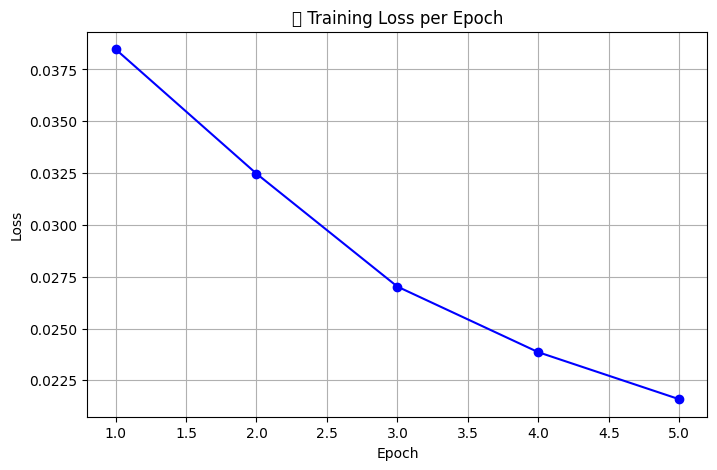

In [10]:
import os
import shutil
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from torch.optim import Adam
from tqdm import tqdm
import random

#  Define the 7 Indian dish folders to use
selected_classes = [
    'butter_chicken',
    'daal_baati_churma',
    'chapati',
    'ras_malai',
    'shrikhand',
    'kachori',
    'palak_paneer'
]

#  Path to full dataset with all 80 classes
original_data_path = "/content/indian_cuisine01/Indian-Food-Dataset/Indian Food Images/Indian Food Images"

#  Create a temp dataset folder for fine-tuning (only 7 classes, 10–20 images each)
filtered_dataset_path = "/content/indian_cuisine"
os.makedirs(filtered_dataset_path, exist_ok=True)

# Copy selected classes and only 10–20 images per class
for class_name in selected_classes:
    src_class_dir = os.path.join(original_data_path, class_name)
    dst_class_dir = os.path.join(filtered_dataset_path, class_name)
    os.makedirs(dst_class_dir, exist_ok=True)

    images = os.listdir(src_class_dir)
    selected_images = random.sample(images, min(len(images), 20))  # select 20 or fewer
    for img in selected_images:
        shutil.copy(os.path.join(src_class_dir, img), os.path.join(dst_class_dir, img))

print(" Selected classes and copied 10–20 images each.")

#  Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

#  Load filtered dataset
dataset = datasets.ImageFolder(root=filtered_dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

print(f"Total images loaded: {len(dataset)}")
print(f"Class-to-Index mapping: {dataset.class_to_idx}")

#  Load pre-trained GoogLeNet
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.googlenet(pretrained=True)

# Binary output: "Indian dish" = 1 (we are training only Indian food, so all = 1)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

#  Training setup
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

#  Wrap dataset so all labels = 1
class PositiveIndianDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset):
        self.base = base_dataset
    def __len__(self):
        return len(self.base)
    def __getitem__(self, idx):
        x, _ = self.base[idx]
        return x, torch.tensor(1.0)  # All labels are Indian

wrapped_dataset = PositiveIndianDataset(dataset)
wrapped_loader = DataLoader(wrapped_dataset, batch_size=16, shuffle=True)

#  Fine-tuning loop
epochs = 5
model.train()

for epoch in range(epochs):
    total_loss = 0
    for images, labels in tqdm(wrapped_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"📘 Epoch [{epoch+1}/{epochs}] Loss: {total_loss / len(wrapped_loader):.4f}")

#  Save model
torch.save(model.state_dict(), "/content/fine_tuned_indian_food_model.pth")
print("🎉 Model saved as 'fine_tuned_indian_food_model.pth'")
import matplotlib.pyplot as plt

#  Track and plot training loss per epoch
train_losses = []

# Modified training loop to track loss
model.train()
for epoch in range(epochs):
    total_loss = 0
    for images, labels in tqdm(wrapped_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(wrapped_loader)
    train_losses.append(avg_loss)
    print(f" Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f}")

#  Save model
torch.save(model.state_dict(), "/content/fine_tuned_indian_food_model.pth")
print("🎉 Model saved as 'fine_tuned_indian_food_model.pth'")

#  Plot training loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), train_losses, marker='o', color='blue')
plt.title(' Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ Selected classes and copied 30–40 images each.
✅ Total images loaded: 350
Class-to-Index mapping: {'butter_chicken': 0, 'chapati': 1, 'daal_baati_churma': 2, 'kachori': 3, 'palak_paneer': 4, 'ras_malai': 5, 'shrikhand': 6}


Epoch 1/30: 100%|██████████| 22/22 [00:06<00:00,  3.34it/s]


📘 Epoch [1/30] Loss: 2.0113


Epoch 2/30: 100%|██████████| 22/22 [00:06<00:00,  3.48it/s]


📘 Epoch [2/30] Loss: 2.0024


Epoch 3/30: 100%|██████████| 22/22 [00:05<00:00,  3.92it/s]


📘 Epoch [3/30] Loss: 1.9464


Epoch 4/30: 100%|██████████| 22/22 [00:07<00:00,  2.96it/s]


📘 Epoch [4/30] Loss: 1.9532


Epoch 5/30: 100%|██████████| 22/22 [00:05<00:00,  3.79it/s]


📘 Epoch [5/30] Loss: 1.9112


Epoch 6/30: 100%|██████████| 22/22 [00:07<00:00,  3.08it/s]


📘 Epoch [6/30] Loss: 1.8906


Epoch 7/30: 100%|██████████| 22/22 [00:05<00:00,  3.99it/s]


📘 Epoch [7/30] Loss: 1.8751


Epoch 8/30: 100%|██████████| 22/22 [00:06<00:00,  3.53it/s]


📘 Epoch [8/30] Loss: 1.8616


Epoch 9/30: 100%|██████████| 22/22 [00:05<00:00,  3.95it/s]


📘 Epoch [9/30] Loss: 1.8406


Epoch 10/30: 100%|██████████| 22/22 [00:06<00:00,  3.43it/s]


📘 Epoch [10/30] Loss: 1.8330


Epoch 11/30: 100%|██████████| 22/22 [00:06<00:00,  3.40it/s]


📘 Epoch [11/30] Loss: 1.8282


Epoch 12/30: 100%|██████████| 22/22 [00:06<00:00,  3.46it/s]


📘 Epoch [12/30] Loss: 1.8030


Epoch 13/30: 100%|██████████| 22/22 [00:05<00:00,  3.92it/s]


📘 Epoch [13/30] Loss: 1.7665


Epoch 14/30: 100%|██████████| 22/22 [00:06<00:00,  3.51it/s]


📘 Epoch [14/30] Loss: 1.7521


Epoch 15/30: 100%|██████████| 22/22 [00:05<00:00,  3.93it/s]


📘 Epoch [15/30] Loss: 1.7565


Epoch 16/30: 100%|██████████| 22/22 [00:06<00:00,  3.52it/s]


📘 Epoch [16/30] Loss: 1.7256


Epoch 17/30: 100%|██████████| 22/22 [00:05<00:00,  3.97it/s]


📘 Epoch [17/30] Loss: 1.6921


Epoch 18/30: 100%|██████████| 22/22 [00:06<00:00,  3.52it/s]


📘 Epoch [18/30] Loss: 1.7160


Epoch 19/30: 100%|██████████| 22/22 [00:05<00:00,  3.97it/s]


📘 Epoch [19/30] Loss: 1.7062


Epoch 20/30: 100%|██████████| 22/22 [00:06<00:00,  3.46it/s]


📘 Epoch [20/30] Loss: 1.6607


Epoch 21/30: 100%|██████████| 22/22 [00:05<00:00,  3.94it/s]


📘 Epoch [21/30] Loss: 1.6670


Epoch 22/30: 100%|██████████| 22/22 [00:06<00:00,  3.48it/s]


📘 Epoch [22/30] Loss: 1.6516


Epoch 23/30: 100%|██████████| 22/22 [00:05<00:00,  3.95it/s]


📘 Epoch [23/30] Loss: 1.6456


Epoch 24/30: 100%|██████████| 22/22 [00:06<00:00,  3.53it/s]


📘 Epoch [24/30] Loss: 1.6507


Epoch 25/30: 100%|██████████| 22/22 [00:05<00:00,  3.93it/s]


📘 Epoch [25/30] Loss: 1.6310


Epoch 26/30: 100%|██████████| 22/22 [00:06<00:00,  3.50it/s]


📘 Epoch [26/30] Loss: 1.6042


Epoch 27/30: 100%|██████████| 22/22 [00:05<00:00,  4.00it/s]


📘 Epoch [27/30] Loss: 1.5822


Epoch 28/30: 100%|██████████| 22/22 [00:06<00:00,  3.51it/s]


📘 Epoch [28/30] Loss: 1.6055


Epoch 29/30: 100%|██████████| 22/22 [00:05<00:00,  3.89it/s]


📘 Epoch [29/30] Loss: 1.5577


Epoch 30/30: 100%|██████████| 22/22 [00:06<00:00,  3.42it/s]


📘 Epoch [30/30] Loss: 1.5500
🎉 Model saved as 'fine_tuned_indian_food_model02.pth'


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


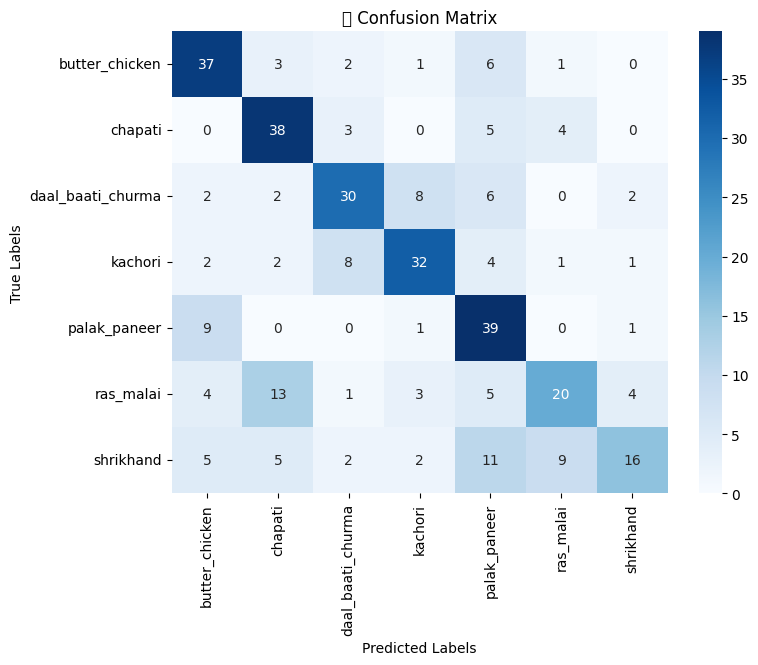

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


📊 Classification Report:
                   precision    recall  f1-score   support

   butter_chicken       0.63      0.74      0.68        50
          chapati       0.60      0.76      0.67        50
daal_baati_churma       0.65      0.60      0.62        50
          kachori       0.68      0.64      0.66        50
     palak_paneer       0.51      0.78      0.62        50
        ras_malai       0.57      0.40      0.47        50
        shrikhand       0.67      0.32      0.43        50

         accuracy                           0.61       350
        macro avg       0.62      0.61      0.59       350
     weighted avg       0.62      0.61      0.59       350



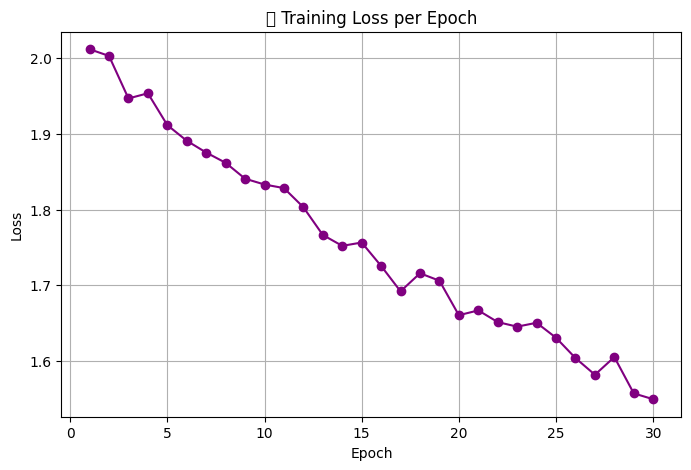

In [9]:

import os
import shutil
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch.optim import Adam
import random
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

# ✅ Define the 7 Indian dish folders to use
selected_classes = [
    'butter_chicken',
    'daal_baati_churma',
    'chapati',
    'ras_malai',
    'shrikhand',
    'kachori',
    'palak_paneer'
]

#  Path to full dataset with all 80 classes
original_data_path = "/content/indian_cuisine01/Indian-Food-Dataset/Indian Food Images/Indian Food Images"

#  Create a temp dataset folder for fine-tuning (only 7 classes, 30–40 images each)
filtered_dataset_path = "/content/indian_cuisine002"
os.makedirs(filtered_dataset_path, exist_ok=True)

# Copy selected classes and only 30–40 images per class
for class_name in selected_classes:
    src_class_dir = os.path.join(original_data_path, class_name)
    dst_class_dir = os.path.join(filtered_dataset_path, class_name)
    os.makedirs(dst_class_dir, exist_ok=True)

    images = os.listdir(src_class_dir)
    selected_images = random.sample(images, min(len(images), 40))  # select 40 or fewer
    for img in selected_images:
        shutil.copy(os.path.join(src_class_dir, img), os.path.join(dst_class_dir, img))

print(" Selected classes and copied 30–40 images each.")

#  Data Augmentation and Transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(40),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
    transforms.RandomResizedCrop(224),
    transforms.RandomAffine(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

#  Load filtered dataset
dataset = datasets.ImageFolder(root=filtered_dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

print(f" Total images loaded: {len(dataset)}")
print(f"Class-to-Index mapping: {dataset.class_to_idx}")

#  Load pre-trained GoogLeNet
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.googlenet(pretrained=True)

# Freeze all layers initially
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the final fully connected layer
for param in model.fc.parameters():
    param.requires_grad = True

#  Modify the final layer for 7 classes (multi-class classification)
model.fc = nn.Sequential(
    nn.Dropout(p=0.3),  # Add Dropout
    nn.Linear(model.fc.in_features, len(selected_classes))
)
model = model.to(device)

#  Reduce learning rate to a smaller value for fine-tuning
optimizer = Adam(model.parameters(), lr=1e-4)  # Use a very small learning rate for fine-tuning

# Training setup
criterion = nn.CrossEntropyLoss()

#  Fine-tuning loop with Scheduler
epochs = 30  # Increased epochs for better training
train_losses = []

# Example of using ReduceLROnPlateau scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for images, labels in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    train_losses.append(avg_loss)

    # Update the learning rate
    scheduler.step(avg_loss)

    print(f"📘 Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f}")

#  Save model
torch.save(model.state_dict(), "/content/fine_tuned_indian_food_model02.pth")
print("🎉 Model saved as 'fine_tuned_indian_food_model02.pth'")

#  Evaluate the model
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in dataloader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

#  Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title('🔍 Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#  Classification Report (Precision, Recall, F1)
print(" Classification Report:")
print(classification_report(all_labels, all_preds, target_names=dataset.classes))

#  Plot Training Loss (for each epoch)
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', color='purple')
plt.title(' Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

